In [ ]:
# Installing Conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# load data
df = pd.read_csv('psmb5_active_inactive_pIC50.csv')

In [ ]:
df

,molecule_chembl_id,canonical_smiles,class,pIC50
0,CHEMBL381735,CC[C@H](C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](...,active,8.619789
1,CHEMBL207670,CC[C@H](C)[C@H](NC(=O)OCc1ccccc1)C(=O)N1CCC[C@...,inactive,3.823909
2,CHEMBL383529,CC(=O)N[C@@H](CCC(=O)OC(C)(C)C)C(=O)N[C@@H](C)...,active,6.585027
3,CHEMBL207336,CC(C)C[C@@H](/C=C/S(C)(=O)=O)NC(=O)[C@H](C)NC(...,active,7.769551
4,CHEMBL208015,CC(C)C[C@@H](/C=C/S(C)(=O)=O)NC(=O)[C@H](C)NC(...,active,8.214670
...,...,...,...,...
691,CHEMBL4519899,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](...,active,8.522879
692,CHEMBL4555159,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]...,active,8.000000
693,CHEMBL4646371,CC(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1ccccc1...,inactive,5.000000
694,CHEMBL4649310,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]...,inactive,5.000000


In [ ]:
# dependencies for lipinski rules and molecular descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
# function for Lipinski
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
# Lipinski values table
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,707.935,3.4912,5.0,8.0
1,606.786,2.9124,3.0,7.0
2,489.635,1.2069,3.0,7.0
3,551.706,2.5008,3.0,7.0
4,581.732,2.9972,3.0,8.0
...,...,...,...,...
691,652.796,4.6420,3.0,6.0
692,624.742,4.3819,3.0,6.0
693,514.623,0.7299,3.0,6.0
694,578.670,0.8138,3.0,8.0


**Statements of the Lipinski descriptors**

Molecular weight < 500 Dalton

Octanol-water partition coefficient (LogP) < 5

Hydrogen bond donors < 5

Hydrogen bond acceptors < 10

In [ ]:
# Combining Lipinski table with the initial df
df_comb = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_comb

,molecule_chembl_id,canonical_smiles,class,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL381735,CC[C@H](C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](...,active,8.619789,707.935,3.4912,5.0,8.0
1,CHEMBL207670,CC[C@H](C)[C@H](NC(=O)OCc1ccccc1)C(=O)N1CCC[C@...,inactive,3.823909,606.786,2.9124,3.0,7.0
2,CHEMBL383529,CC(=O)N[C@@H](CCC(=O)OC(C)(C)C)C(=O)N[C@@H](C)...,active,6.585027,489.635,1.2069,3.0,7.0
3,CHEMBL207336,CC(C)C[C@@H](/C=C/S(C)(=O)=O)NC(=O)[C@H](C)NC(...,active,7.769551,551.706,2.5008,3.0,7.0
4,CHEMBL208015,CC(C)C[C@@H](/C=C/S(C)(=O)=O)NC(=O)[C@H](C)NC(...,active,8.214670,581.732,2.9972,3.0,8.0
...,...,...,...,...,...,...,...,...
691,CHEMBL4519899,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](...,active,8.522879,652.796,4.6420,3.0,6.0
692,CHEMBL4555159,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]...,active,8.000000,624.742,4.3819,3.0,6.0
693,CHEMBL4646371,CC(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1ccccc1...,inactive,5.000000,514.623,0.7299,3.0,6.0
694,CHEMBL4649310,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]...,inactive,5.000000,578.670,0.8138,3.0,8.0


In [ ]:
# saving active and inactive df
df_comb.to_csv('psmb5_lipinski_class_pIC50.csv', index=False)

LIPINSKI ANALYSIS

In [ ]:
# dependencies
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

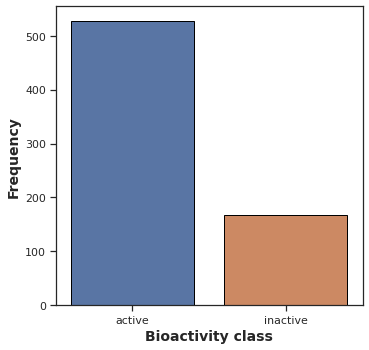

In [ ]:
# Frecuency plot of active and inactive ligands
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_comb, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

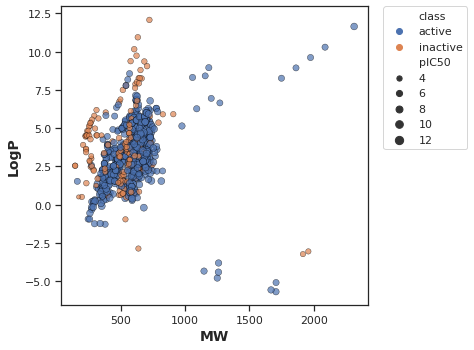

In [ ]:
# MW vs. LogP scatter plot
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_comb, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0, 0.5, 'pIC50 value')

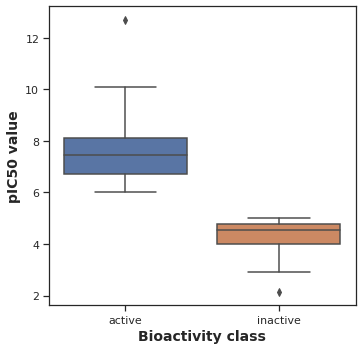

In [ ]:
# pIC50 box plot
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_comb)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

**Statistical analysis (Mann-Whitney) for bioactivity classes and Lipinski statements**

In [ ]:
# Function to work with all variables
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_comb[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_comb[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

pIC50

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,2.413482e-85,0.05,Different distribution (reject H0)


Text(0, 0.5, 'pIC50')

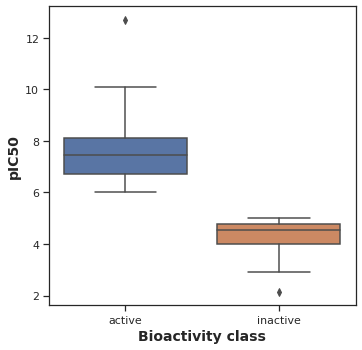

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_comb)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')

MW

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,34653.5,0.00001,0.05,Different distribution (reject H0)


Text(0, 0.5, 'MW')

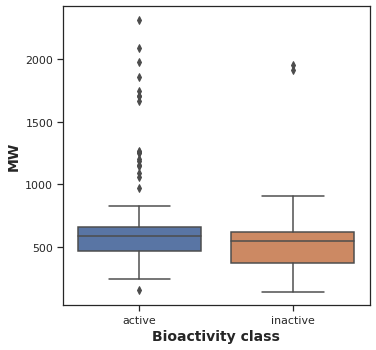

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_comb)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

LogP

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,41208.5,0.083076,0.05,Same distribution (fail to reject H0)


Text(0, 0.5, 'LogP')

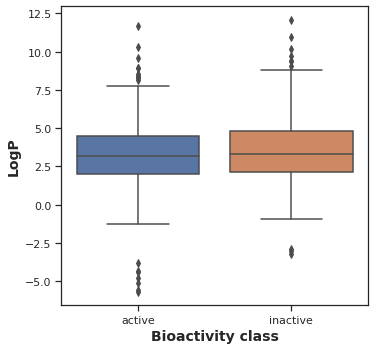

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_comb)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

NumHDonors

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,38108.5,0.002337,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHDonors')

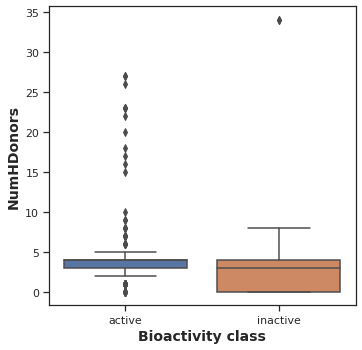

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_comb)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

NumHAcceptors

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,36243.0,0.000143,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHAcceptors')

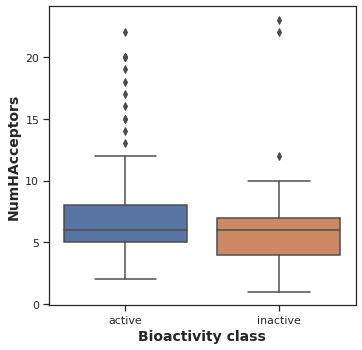

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_comb)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

For the Lipinski descriptors is strong evidence that the diference between medians of active and inactive compounds is statistically significant for molecular weight (< 500Da), and the H+ (both donor and acceptor). In the other hand, for the octanol water partition coefficent of the classes we need more evidence to conclude differences.